# 3. Model tests
## 3.03 Example: Support Vector Regression Model

In [25]:
import sys
sys.path.append("../../")
print(sys.executable)
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import dask
dask.config.set(scheduler='threads')
import xarray as xr

from python.aux.utils_floodmodel import add_time, generate_prediction_array, remove_outlier, multi_forecast_case_study
from python.aux.plot import plot_multif_prediction

import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

from sklearn.svm import SVR

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/bin/python3


## Loading the data
Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data.

The features are already prepared and ready to use, hence why they can be loaded directly from the `features_xy.nc` file.

Let's open the files and see what's in there:

In [2]:
# load data
features = xr.open_dataset('../../data/features_xy.nc')
y = features['dis']
X = features.drop(['dis', 'dis_diff'])

In [3]:
features

<xarray.Dataset>
Dimensions:     (time: 13514)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables:
    cp          (time) float32 ...
    lsp         (time) float32 ...
    swvl1       (time) float32 ...
    ro          (time) float32 ...
    sd          (time) float32 ...
    sd_diff     (time) float32 ...
    lsp-4-11    (time) float32 ...
    lsp-12-25   (time) float32 ...
    lsp-26-55   (time) float32 ...
    lsp-56-180  (time) float32 ...
    lsp-1       (time) float32 ...
    lsp-2       (time) float32 ...
    lsp-3       (time) float32 ...
    cp-1        (time) float32 ...
    cp-2        (time) float32 ...
    cp-3        (time) float32 ...
    dis         (time) float64 ...
    dis_diff    (time) float64 ...

Some control parameters for the procedure:

 * `add_shift_switch`: Shift and add shifted values as new features for multi-day forecasts. (only needed if forecasting multiple days at once => currently only implemented with nns!)
 * `dis_shift_1`: Add the discharge from the last day as additional feature for testing purposes.
 * `abs_vals_switch`: Model is trained on absolute discharge values if True and on differences/change in discharge else.

In [4]:
dis_shift_switch = False

In [5]:
abs_vals_switch = False

Begin with some short preprocessing..

In [6]:
if dis_shift_switch:
    dis_shift_1 = y.shift(time=1)
    X = X.assign({'dis-1': dis_shift_1})

In [7]:
X_base = X.to_array(dim='features').T.copy()
y_base = y.copy()

Next, we split the dataset into three parts for 
- training (the longest period for estimating the free parameters within the model), 
- validation (for tuning hyperparameters) and 
- testing (for the model comparison).

In [8]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))

In [9]:
X_train, y_train = X_base.loc[period_train], y_base.loc[period_train]
X_valid, y_valid = X_base.loc[period_valid], y_base.loc[period_valid]
X_test, y_test = X_base.loc[period_test], y_base.loc[period_test]

In [10]:
X_train.shape, y_train.shape

((9131, 16), (9131,))

In [11]:
time = y_train.time
Xda = X_train.chunk(dict(time=-1, features=-1)).dropna(dim='time').to_pandas()

if abs_vals_switch:
    # train on absolute values
    yda = y_train.to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]
else:
    # train on change in discharge values
    yda = y_train.diff(dim='time').to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]

# Define SupportVectorRegression Model

In [12]:
model = SVR(kernel='poly',
            C=100,
            epsilon=0.01,
            degree=3,
           )

pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', model),], verbose=True)

In [13]:
x_fit = Xda.copy()
y_fit = yda.copy()
pipe.fit(x_fit, y_fit)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.1min


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
                     gamma='auto_deprecated', kernel='poly', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=True)

### in sample test for the predicted change, to verify functionality

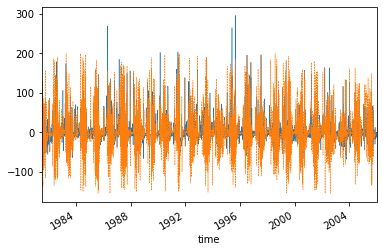

In [14]:
Xda_insample = Xda.copy()
insample_check = pipe.predict(Xda_insample)
insample_check = add_time(insample_check, Xda_insample.index, name='forecast')
insample_check.where(insample_check > insample_check.quantile(0.01)).to_pandas().plot(linewidth=0.5)
yda.plot(linestyle='--', linewidth=0.5)

#### Note that the insample test shows, that the forecasted discharge change is about one order of magnitude over the real one, indicating .

Set the frequency at which forecast are started.

In [15]:
# prediction start from every nth day
# if in doubt, leave n = 1 !!!
n = 1
X_pred = X_valid[::n].copy()
y_pred = pipe.predict(X_pred.values)
y_pred = add_time(y_pred, X_pred.time, name='forecast')
print(y_pred)

<xarray.DataArray 'forecast' (time: 2191)>
array([-23.304232,  -6.446165,   7.159433, ..., -13.119787, -29.297236,
         8.139587])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2011-12-31


(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8e5c6b5978>)

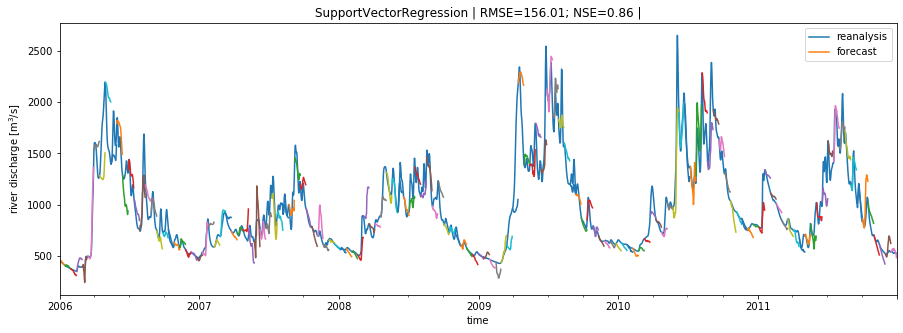

In [16]:
multif = generate_prediction_array(y_pred, y, forecast_range=14)
plot_multif_prediction(multif, y, forecast_range=14, title='SupportVectorRegression')

#### Check the skill of a 14-day persistence forecast:

In [17]:
forecast_range = 14
y_o_pers = y_valid
# persistence
y_m_pers = y_valid.copy()
for i in range(1, forecast_range):
    y_m_pers.loc[y_valid.time[i::forecast_range]] = y_valid.shift(time=i)[i::forecast_range].values
    
rmse = np.sqrt(np.nanmean((y_m_pers - y_o_pers)**2))
nse = 1 - np.sum((y_m_pers - y_o_pers)**2)/(np.sum((y_o_pers - np.nanmean(y_o_pers))**2))
print(f"Persistence {forecast_range}-day forecast: RMSE={round(float(rmse), 2)}; NSE={round(float(nse.values), 2)}")

Persistence 14-day forecast: RMSE=210.1; NSE=0.75


Now, lets run a few different settings and compare the results:

|   kernel    |   C   |  epsilon   |   degree    |   RMSE   |   NSE   | 
| :--------: | :-----: | :-----: | :-----: | :-----: |:-----: |
| rbf | 1 | 0.01 | 1 | 168.75 | 0.85
| rbf | 1 | 0.1 | 1 | 168.75 | 0.85
| rbf | 1 | 1 | 1 | 168.46 | 0.85
| rbf | 10 | 0.01 | 1 | 149.12 | 0.88
| rbf | 10 | 0.1 | 1 | 149.08 | 0.88
| rbf | 10 | 1 | 1 | 148.71 | 0.88
| rbf | 100 | 0.01 | 1 | 141.73 | 0.9
| rbf | 100 | 0.1 | 1 | 141.72 | 0.9
| rbf | 100 | 1 | 1 | 141.44 | 0.9
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| poly | 1 | 0.01 | 1 | 165.9 | 0.86
| poly | 1 | 0.01 | 2 | 170.38 | 0.85
| poly | 1 | 0.01 | 3 | 153.21 | 0.88
| poly | 1 | 0.01 | 4 | 171.13 | 0.85
| poly | 1 | 0.01 | 5 | 169.08 | 0.85
| poly | 1 | 0.1 | 1 | 165.88 | 0.86
| poly | 1 | 0.1 | 2 | 170.43 | 0.85
| poly | 1 | 0.1 | 3 | 153.18 | 0.88
| poly | 1 | 0.1 | 4 | 171.11 | 0.85
| poly | 1 | 0.1 | 5 | 169.08 | 0.85
| poly | 1 | 1 | 1 | 165.81 | 0.86
| poly | 1 | 1 | 2 | 170.12 | 0.85
| poly | 1 | 1 | 3 | 153.18 | 0.88
| poly | 1 | 1 | 4 | 170.98 | 0.85
| poly | 1 | 1 | 5 | 169.39 | 0.85
| poly | 10 | 0.01 | 1 | 163.47 | 0.86
| poly | 10 | 0.01 | 2 | 165.24 | 0.86
| poly | 10 | 0.01 | 3 | 142.95 | 0.89
| poly | 10 | 0.01 | 4 | 166.34 | 0.86
| poly | 10 | 0.01 | 5 | 245.8 | 0.69
| poly | 10 | 0.1 | 1 | 163.49 | 0.86
| poly | 10 | 0.1 | 2 | 165.19 | 0.86
| poly | 10 | 0.1 | 3 | 142.95 | 0.89
| poly | 10 | 0.1 | 4 | 166.43 | 0.86
| poly | 10 | 0.1 | 5 | 245.43 | 0.69
| poly | 10 | 1 | 1 | 163.55 | 0.86
| poly | 10 | 1 | 2 | 165.11 | 0.86
| poly | 10 | 1 | 3 | 142.62 | 0.89
| poly | 10 | 1 | 4 | 166.45 | 0.86
| poly | 10 | 1 | 5 | 241.66 | 0.7
| poly | 100 | 0.01 | 1 | 163.23 | 0.86
| poly | 100 | 0.01 | 2 | 163.95 | 0.86
| poly | 100 | 0.01 | 3 | 138.08 | 0.9
| poly | 100 | 0.01 | 4 | 200.86 | 0.79
| poly | 100 | 0.01 | 5 | 577.91 | -0.74
| poly | 100 | 0.1 | 1 | 163.29 | 0.86
| poly | 100 | 0.1 | 2 | 163.99 | 0.86
| poly | 100 | 0.1 | 3 | 138.17 | 0.9
| poly | 100 | 0.1 | 4 | 200.84 | 0.79
| poly | 100 | 0.1 | 5 | 577.81 | -0.74
| poly | 100 | 1 | 1 | 163.23 | 0.86
| poly | 100 | 1 | 2 | 164.18 | 0.86
| poly | 100 | 1 | 3 | 138.25 | 0.9
| poly | 100 | 1 | 4 | 199.33 | 0.79
| poly | 100 | 1 | 5 | 574.59 | -0.72
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| persistence 14-day forecast  | |  | | 251.09 | 0.77 |



Concluding, a polynomial degree of 2 works best for the 'poly' kernel. It seems that the value of `epsilon` does not matter that much and even the impact of varying `C` is rather negligible. For the best setting, with `kernel='poly'`, `C=100`, `epsilon=0.01` and `degree=3`, the metrics `RMSE=138.08` and `NSE=0.9` are comparable to the result of the LinearRegressionModel, but this may be intriguing, as the insample test above shows, that the model exhibits some strange behaviour, which might indicate that SVR is just not a good model for predicting such kind of time series (even if the metrics for the validation period seem ok).

## Prediction for the test data (used in the model evaluation notebook for comparison)
Note that the optimized model setting is already updated in the model call far above.

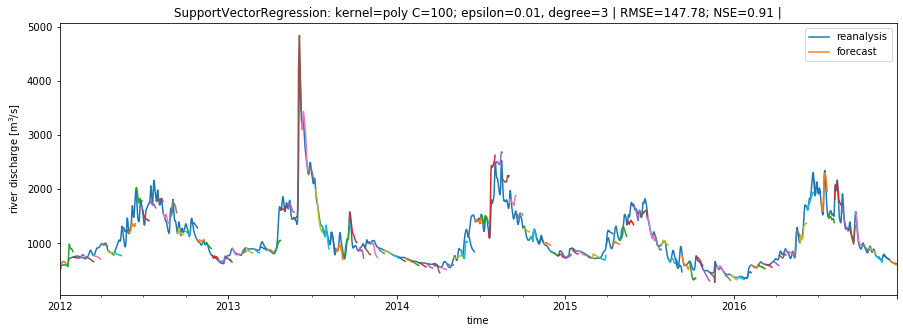

In [18]:
# prediction start from every nth day
# if in doubt, leave n = 1 !!!
n = 1
X_pred = X_test[::n].copy()
y_pred = pipe.predict(X_pred)
y_pred = add_time(y_pred, X_pred.time, name='forecast')

multif_test = generate_prediction_array(y_pred, y, forecast_range=14)
plot_multif_prediction(multif_test, y, forecast_range=14, title='SupportVectorRegression: kernel=poly C=100; epsilon=0.01, degree=3');

## Case study: May/June 2013; Flooding event at Krems (Danube river)

Drop long time feature not available for the period of interest and do the same preparation steps as before.

In [19]:
X_multif_fin, X_multifr_fin, y_case_fin = multi_forecast_case_study(pipe, X_test, y)

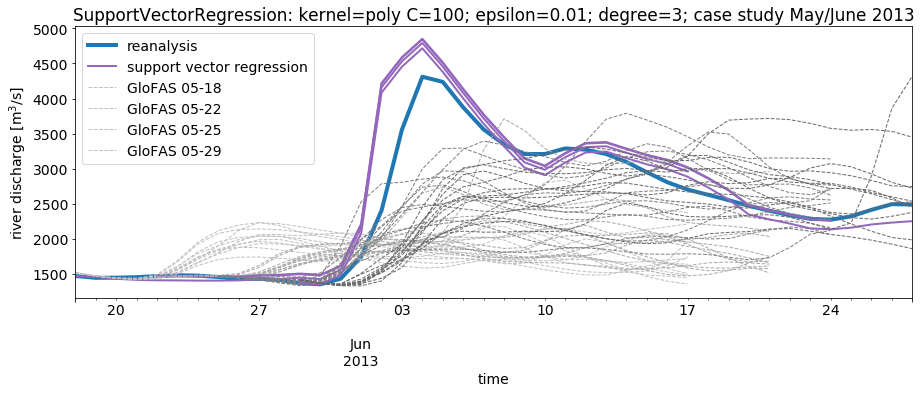

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
frerun_c = ['silver', 'darkgray', 'gray', 'dimgray']

y_case_fin.to_pandas().plot(ax=ax, label='reanalysis', linewidth=4)
run = 0
for i in X_multifr_fin.num_of_forecast:
    X_multif_fin.sel(num_of_forecast=i).to_pandas().T.plot(ax=ax, label='forecast',
                                                           linewidth=2, color='tab:purple')
    X_multifr_fin.sel(num_of_forecast=i).to_pandas().T.plot(ax=ax, label='frerun', linewidth=1,
                                                            linestyle='--', color=frerun_c[run])
    run += 1
ax.set_ylabel('river discharge [m$^3$/s]')
plt.legend(['reanalysis', 'support vector regression', 'GloFAS 05-18', 'GloFAS 05-22', 'GloFAS 05-25', 'GloFAS 05-29'])
plt.title('SupportVectorRegression: kernel=poly C=100; epsilon=0.01; degree=3; case study May/June 2013');
plt.savefig('svr_case.png', dpi=600, bbox_inches='tight')

Save the postprocessed model forecast, as well as the forecast rerun and the reanalysis data.

In [22]:
X_multif_fin.to_netcdf('../../data/models/SVR/support_vector_regression_result_case_study.nc', mode='w')

Save data of the test period for the model comparison.

In [24]:
multif_test.to_netcdf('../../data/models/SVR/support_vector_regression_result_test_period.nc', mode='w')